In [335]:
import pfv_utils.utils as pu
from pfv_utils.utils import conv_and_relu, max_pool_2x2, add_conv_layer
import vision.data.proto.annotated_image_pb2
import vision.data.proto.oriented_bounding_box_annotation_extension_pb2
import vision.data.tools.fiducial_annotator.fiducial_annotator_pb2
import tensorflow as tf
import numpy as np
import os

In [336]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [359]:
class TLDetectorNet:
    def __init__(self):
        # Image
        self.x = tf.placeholder(tf.float32, shape=[None, 90,30,3], name="input")
        self.shape_y = tf.placeholder(tf.int32, shape = [None, 90,30])
        self.shape_loss_mask = tf.placeholder(tf.float32, shape = [None, 90,30])
        self.color_loss_mask = tf.placeholder(tf.float32, shape = [None, 90,30])
        self.color_y = tf.placeholder(tf.int32, shape = [None, 90,30])


        self.conv0 = conv_and_relu(self.x, [5,5,3,32], stride=1)
        conv1 = conv_and_relu(self.conv0, [5,5,32,32], stride=1)
                
        #mp0 = max_pool_2x2(conv1)
        conv2 = conv_and_relu(conv1, [5,5,32,32], stride=1)
        conv3 = conv_and_relu(conv2, [5,5,32,32], stride=1)
        
        #mp2 = max_pool_2x2(conv3)
        conv4_shape = conv_and_relu(conv3, [5,5,32,32], stride=1)
        conv5_shape = conv_and_relu(conv4_shape, [5,5,32,32], stride=1)
        self.shape_output_logits = tf.image.resize_bilinear(pu.add_conv_layer(conv5_shape, [5,5,32,4], stride=1),
                                                            [90,30])
        
        self.shape_output=tf.nn.softmax(self.shape_output_logits)
        
        self.shape_loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.shape_y, 
                                                            logits=self.shape_output_logits) * self.shape_loss_mask)

        # Color outputs: red, green, yellow: should be softmax        
        conv4_color = conv_and_relu(conv3, [5,5,32,32], stride=1)
        conv5_color = conv_and_relu(conv4_color, [5,5,32,32], stride=1)
        self.color_output_logits = tf.image.resize_bilinear(add_conv_layer(conv5_color, [5,5,32,4], stride=1), [90,30])
        self.color_output=tf.nn.softmax(self.color_output_logits)
        
        self.color_loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.color_y, 
                                                            logits=self.color_output_logits) * self.color_loss_mask)
        
        
        self.loss = self.shape_loss + self.color_loss
        

In [360]:
tl_net = TLDetectorNet()

In [361]:
tl_net.shape_output_logits

<tf.Tensor 'ResizeBilinear_7:0' shape=(?, 90, 30, 4) dtype=float32>

In [362]:
tl_net.shape_loss

<tf.Tensor 'Sum_7:0' shape=() dtype=float32>

In [363]:
tl_net.color_loss

<tf.Tensor 'Sum_8:0' shape=() dtype=float32>

In [364]:
lmdb_dir = '/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes/'
lmdbs = []
for f in sorted(os.listdir(lmdb_dir)):
    if f.endswith('lock'):
        continue
    if '_' in f:
        continue
    light_id = int(f.split('.')[0])
    if light_id not in [3001, 3002, 3003, 3004, 3006, 3007]:
        continue
    path = lmdb_dir + '/' + f
    print path
    lmdb = pu.LMDBIterator(path)
    lmdbs.append(lmdb)
    
print str(len(lmdbs))

/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes//3001.lmdb
/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes//3002.lmdb
/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes//3003.lmdb
/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes//3004.lmdb
/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes//3006.lmdb
/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes//3007.lmdb
6


In [365]:
batch_size = 1

In [366]:
# circle: 0, left arrow 1, right arrow: 2

In [367]:
def tl_label_to_shape_idx(tl_label):
    m = {3001:0, 3002: 1, 3003: 2, 3004: 0, 3005: 1, 3006: 2,3007:0, 3008:1, 3009:2}
    return m[tl_label]

In [368]:
def tl_label_to_color_idx(tl_label):
    m = {3001:0, 3002: 0, 3003: 0, 3004: 1, 3005: 1, 3006: 1,3007:2, 3008:2, 3009:2}
    return m[tl_label]

In [369]:
def get_lr_mirror_shape_label(shape_label):
    d = {0:0, 1:2, 2:1, 3:3}
    return d[shape_label]

In [370]:
def get_mirror_shape_labels(shape_labels_in):
    shape_labels = shape_labels_in.copy()
    shape_labels[shape_labels_in == 1] = 2
    shape_labels[shape_labels_in == 2] = 1
    return shape_labels
    

In [371]:
def region_to_labels_and_masks(ai):
    # Shape labels
    # Color labels
    # Loss mask
    shape_labels = np.zeros((ai.height,ai.width)) + 3
    color_labels = np.zeros((ai.height, ai.width)) + 3
    
    loss_mask = np.zeros((ai.height, ai.width))
    region = ai.groundtruth[0].region
    ctr = ((region.x1 + region.x2) / 2.0, (region.y1 + region.y2) / 2.0)
    
    xs = np.tile(np.arange(0,ai.width), (ai.height,1))
    ys = np.tile(np.arange(0,ai.height), (ai.width,1)).T
    
    dists = np.sqrt(np.power((xs - ctr[0]),2) + np.power((ys-ctr[1]),2))
    
    inner_mask = (dists < 5) 
    outer_mask = ( dists > 20)
    loss_mask =inner_mask + 0.0 + outer_mask
    
    label = ai.groundtruth[0].region.attribute[0].label
    color_idx = tl_label_to_color_idx(label)
    color_labels = (1-inner_mask) * color_labels + inner_mask * color_idx
    
    shape_idx = tl_label_to_shape_idx(label)
    shape_labels = (1-inner_mask) * shape_labels + inner_mask * shape_idx
    
    
    return shape_labels, color_labels, loss_mask
    
    

In [372]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(tl_net.loss)

In [373]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_iter = -1

In [374]:
import time

In [375]:
losses = []
shape_losses = []
color_losses = []

In [376]:
np.max(gray_im)

0.97376392156862757

In [453]:
while train_iter < 100000:
    train_iter += 1
    
    batch_ims = []
    batch_gts = []
    batch_color_loss_masks = []
    batch_shape_loss_masks = []
    batch_shape_labels = []
    batch_color_labels = []
    
    batch_item_idx = -1
    for lmdb in lmdbs:
        for i in range(0,batch_size):
            batch_item_idx +=1
            ai = vision.data.proto.annotated_image_pb2.AnnotatedImage()
            ai.ParseFromString(lmdb.kv_pair[1])
            lmdb.next()
            
            label = ai.groundtruth[0].region.attribute[0].label
            im = pu.get_image_from_ai(ai)
            shape_labels, color_labels, loss_mask = region_to_labels_and_masks(ai)
            batch_shape_labels.append(shape_labels)
            batch_color_labels.append(color_labels)
            batch_shape_loss_masks.append(loss_mask)
            batch_color_loss_masks.append(loss_mask)

            batch_ims.append(im)

            # L-R augmentation
            lr_shape_labels = get_mirror_shape_labels(shape_labels)
            batch_shape_labels.append(lr_shape_labels)
            batch_color_labels.append(color_labels)
            batch_shape_loss_masks.append(loss_mask)
            batch_color_loss_masks.append(loss_mask)

            batch_ims.append(np.fliplr(im))
            
            # U-D augmentation
            batch_shape_labels.append( np.flipud(shape_labels))
            batch_color_labels.append(np.flipud(color_labels))
            batch_shape_loss_masks.append(loss_mask)
            batch_color_loss_masks.append(loss_mask)
            batch_ims.append(np.flipud(im))
            
            # Grayscale augmentation
            gray_im = np.rollaxis(np.tile(skimage.color.rgb2gray(im), (3,1,1)), 0, 3)
            batch_shape_labels.append(shape_labels)
            batch_color_labels.append(color_labels)
            batch_shape_loss_masks.append(loss_mask)
            batch_color_loss_masks.append(loss_mask * 0)
            batch_ims.append(gray_im * 255.0)
            
            swap_im = im[:,:,[2,1,0]]
            batch_shape_labels.append(shape_labels)
            batch_color_labels.append(color_labels)
            batch_shape_loss_masks.append(loss_mask)
            batch_color_loss_masks.append(loss_mask * 0)
            batch_ims.append(swap_im)
            
            swap_im = im[:,:,[0,2,1]]
            batch_shape_labels.append(shape_labels)
            batch_color_labels.append(color_labels)
            batch_shape_loss_masks.append(loss_mask)
            batch_color_loss_masks.append(loss_mask * 0)
            batch_ims.append(swap_im)
            
            swap_im = im[:,:,[1,2,0]]
            batch_shape_labels.append(shape_labels)
            batch_color_labels.append(color_labels)
            batch_shape_loss_masks.append(loss_mask)
            batch_color_loss_masks.append(loss_mask * 0)
            batch_ims.append(swap_im)
            

            
        
    normalized_batch_ims = pu.normalize_ims(np.array(batch_ims))
    
    step_start = time.time()
    loss, shape_loss, color_loss,conv_0,_ = sess.run([tl_net.loss, tl_net.shape_loss, tl_net.color_loss, tl_net.conv0, train_step], 
                                            feed_dict={tl_net.x: normalized_batch_ims,
                                          tl_net.shape_y: np.array(batch_shape_labels), 
                                           tl_net.shape_loss_mask: np.array(batch_shape_loss_masks),
                                            tl_net.color_loss_mask: np.array(batch_color_loss_masks),

                                                              tl_net.color_y: np.array(batch_color_labels)})
    losses.append(loss)
    shape_losses.append(shape_loss)
    color_losses.append(color_loss)
    
    if train_iter % 100 == 0:
        print 'Iter: %d loss: %f' % (train_iter, loss)

            #batch_extents_gts[batch_item_idx,:] = pu.get_extents_from_ai(ai)
            #batch_extents_loss_mask[batch_item_idx] = 1
    

Iter: 44900 loss: 1853.882568
Iter: 45000 loss: 2025.601807
Iter: 45100 loss: 930.310059
Iter: 45200 loss: 2066.080322
Iter: 45300 loss: 1556.864502
Iter: 45400 loss: 1643.525635
Iter: 45500 loss: 791.893677
Iter: 45600 loss: 654.620117
Iter: 45700 loss: 691.956604
Iter: 45800 loss: 1924.567017
Iter: 45900 loss: 819.831055
Iter: 46000 loss: 1045.328003
Iter: 46100 loss: 1347.774658
Iter: 46200 loss: 1447.861084
Iter: 46300 loss: 1399.293823
Iter: 46400 loss: 1581.635010
Iter: 46500 loss: 1639.273804
Iter: 46600 loss: 900.412964
Iter: 46700 loss: 1064.870850
Iter: 46800 loss: 953.696533
Iter: 46900 loss: 1521.466797
Iter: 47000 loss: 967.219238
Iter: 47100 loss: 1188.184326
Iter: 47200 loss: 1058.528076
Iter: 47300 loss: 2704.548340
Iter: 47400 loss: 1490.444336
Iter: 47500 loss: 1663.759399
Iter: 47600 loss: 1908.065308
Iter: 47700 loss: 871.199341
Iter: 47800 loss: 844.828613
Iter: 47900 loss: 2556.883789
Iter: 48000 loss: 1022.725098
Iter: 48100 loss: 1434.389038
Iter: 48200 loss: 36

Iter: 72600 loss: 922.614868
Iter: 72700 loss: 947.241455
Iter: 72800 loss: 755.996399
Iter: 72900 loss: 1170.667236
Iter: 73000 loss: 1157.364868
Iter: 73100 loss: 1495.651245
Iter: 73200 loss: 573.009033
Iter: 73300 loss: 1048.729004
Iter: 73400 loss: 942.690735
Iter: 73500 loss: 694.168884
Iter: 73600 loss: 1108.951660
Iter: 73700 loss: 567.679016
Iter: 73800 loss: 1585.533936
Iter: 73900 loss: 1662.199341
Iter: 74000 loss: 626.845215
Iter: 74100 loss: 909.519287
Iter: 74200 loss: 1426.404053
Iter: 74300 loss: 1061.443604
Iter: 74400 loss: 4610.197754
Iter: 74500 loss: 1014.460693
Iter: 74600 loss: 1035.105713
Iter: 74700 loss: 1355.887939
Iter: 74800 loss: 937.507812
Iter: 74900 loss: 1535.227417
Iter: 75000 loss: 1195.117065
Iter: 75100 loss: 2764.688965
Iter: 75200 loss: 2309.750488
Iter: 75300 loss: 1247.164062
Iter: 75400 loss: 1721.911865
Iter: 75500 loss: 616.792480
Iter: 75600 loss: 621.271606
Iter: 75700 loss: 937.472473
Iter: 75800 loss: 1127.438232
Iter: 75900 loss: 1115.

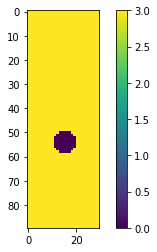

In [769]:
plt.imshow(shape_labels)
plt.colorbar()

In [425]:
import scipy.signal as ss


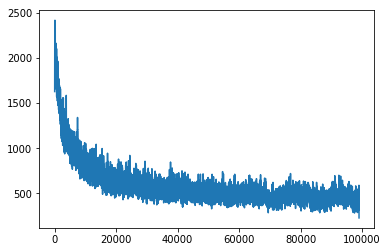

In [454]:
some_losses = ss.medfilt(color_losses[1000:], 21)

plt.plot(np.arange(len(some_losses)), some_losses)

In [273]:
out, color_out = sess.run([tl_net.shape_output,tl_net.color_output], feed_dict={tl_net.x:  normalized_batch_ims})

In [274]:
out.shape

(42, 90, 30, 4)

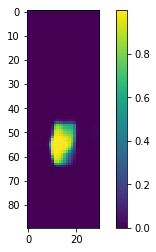

In [284]:
plt.imshow(color_out[40,:,:,0])
plt.colorbar()

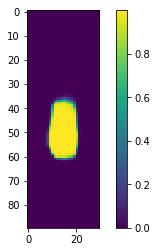

In [295]:
plt.imshow(out[32,:,:,2])
plt.colorbar()

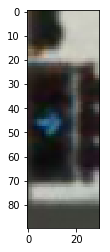

In [294]:
plt.imshow(normalized_batch_ims[32,:,:,::-1] + 0.5)

In [296]:
lmdb_dir

'/mnt/nautilus_rw/praveen/tl/2018/09/25/per_light_boxes/'

In [763]:
#p = ['3004_3009.lmdb', 100] # yellow circle and green arrow
p = ['3007_3008_3009.lmdb', 1]

test_lmdb = pu.LMDBIterator(lmdb_dir + '/%s' % p[0])
for i in range(0,p[1]):
    test_lmdb.next()
    
test_ai = vision.data.proto.annotated_image_pb2.AnnotatedImage()
test_ai.ParseFromString(test_lmdb.kv_pair[1])
test_im = pu.get_image_from_ai(test_ai)

In [764]:
test_shape_out, test_color_out = sess.run([tl_net.shape_output,tl_net.color_output], feed_dict={tl_net.x:  
                                                                                                [pu.normalize_ims(test_im)]})

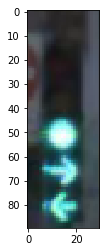

In [765]:
plt.imshow(test_im[:,:,::-1])

In [778]:
np.unravel_index(np.argmax(test_shape_out[0,:,:,0]), (90,30))

(52, 16)

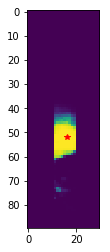

In [780]:
plt.imshow(test_shape_out[0,:,:,0])
plt.plot(16,52,'r*')

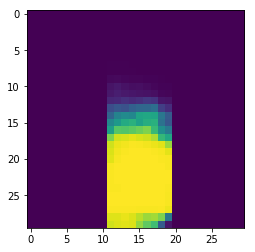

In [771]:
plt.imshow(test_shape_out[0,30:60,:,0])

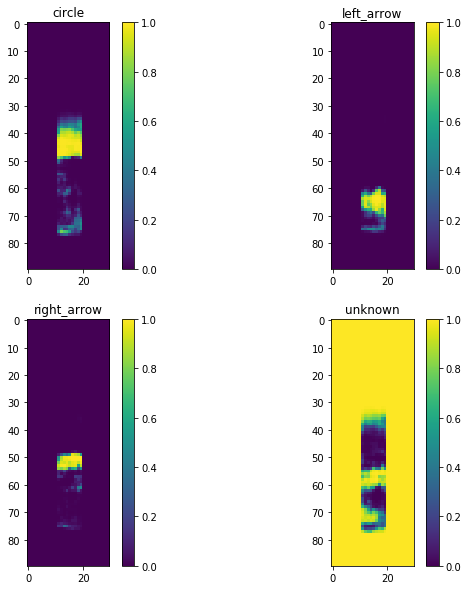

In [761]:
idx_to_name = ['circle', 'left_arrow', 'right_arrow', 'unknown']
plt.figure(figsize=(10,10))
for i in range(0,4):
    plt.subplot(2,2,i+1)

    plt.imshow(test_shape_out[0,:,:,i],vmin=0,vmax=1 )
    plt.title('%s' % idx_to_name[i])
    plt.colorbar()

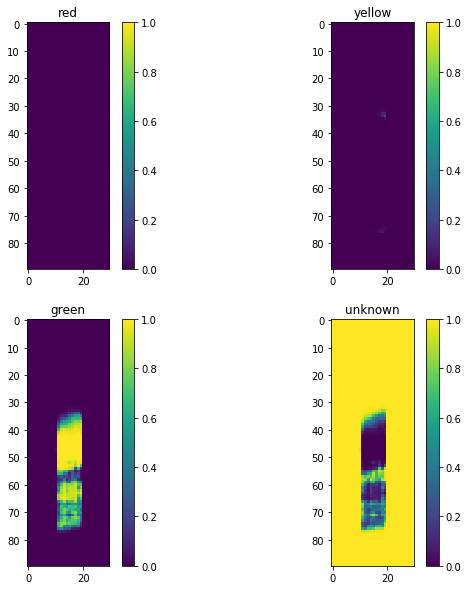

In [762]:
idx_to_name = ['red', 'yellow', 'green', 'unknown']
plt.figure(figsize=(10,10))
for i in range(0,4):
    plt.subplot(2,2,i+1)

    plt.imshow(test_color_out[0,:,:,i],vmin=0,vmax=1 )
    plt.title('%s' % idx_to_name[i])
    plt.colorbar()

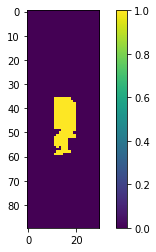

In [621]:
plt.imshow(test_shape_out[0,:,:,0] > 0.5)
plt.colorbar()

In [ ]:
batch_color_labels[0].dtype

In [ ]:
np.sum(np.isnan(np.array(batch_shape_labels)))

In [ ]:
#tl_label_to_shape_idx(ai.groundtruth[0].region.attribute[0].label)
tl_label_to_color_idx(3001)

In [ ]:
ai.width

In [ ]:
shape_labels, color_labels,loss_mask=region_to_labels_and_masks(ai)

In [ ]:
plt.imshow(loss_mask)

In [ ]:
plt.imshow(color_labels)
plt.colorbar()

In [ ]:
plt.imshow(pu.get_image_from_ai(ai))

In [ ]:
np.max(loss_mask)

In [ ]:
plt.imshow(loss_mask)


In [ ]:
ai.groundtruth[0]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline